In [50]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
sns.set_style('whitegrid')

In [51]:
#đọc dữ liệu hình ảnh, chuyển đổi
p = Path("data/")
dirs = p.glob("*")
labels_dict = {'IncorrectlyWornMask':0,'WithMask':1,'WithoutMask':2 }
image_data = [] 
labels = []
for folder_dir in dirs:
    print(str(folder_dir))
    label = str(folder_dir).split("/")[-1]
    print("doc anh thanh cong thu muc:",label)
    for img_path in folder_dir.glob("*"):
        img = image.load_img(img_path, target_size=(32,32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])

print("image_data train",len(image_data))
print("Labels train",len(labels))



data/IncorrectlyWornMask
doc anh thanh cong thu muc Train: IncorrectlyWornMask
data/WithoutMask
doc anh thanh cong thu muc Train: WithoutMask
data/WithMask
doc anh thanh cong thu muc Train: WithMask
image_data train 2079
Labels train 2079


In [52]:

image_data = np.array(image_data, dtype='float32')/255.0
labels = np.array(labels)



image_data.shape



(2079, 32, 32, 3)

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=45)

image_data.shape

(2079, 32, 32, 3)

<Axes: xlabel='label', ylabel='count'>

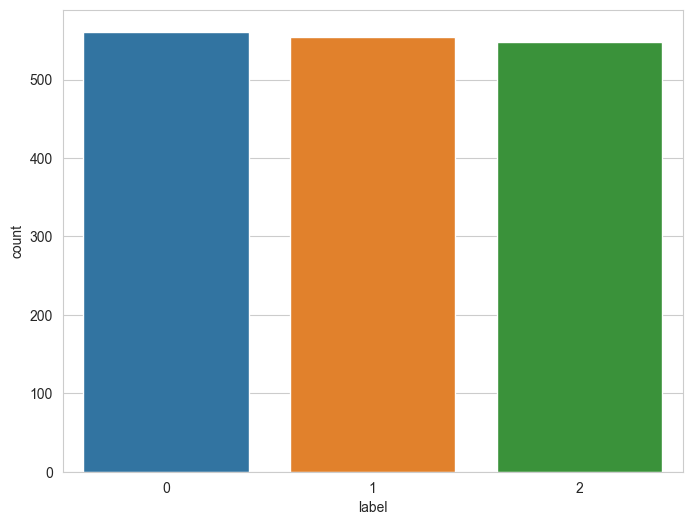

In [54]:
#so sanh dữ liệu train
df_labels = pd.DataFrame(
    y_train,
    columns=['label']
)
plt.figure(figsize=(8, 6))
sns.countplot(data=df_labels, x='label')

In [61]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
   #  soft margin và  hard margin
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        loss += 0.5*np.dot(W,W.T) #T chuyển vị 
        m = X.shape[0] # số dòng dữ liệu mẫu
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))

        return loss[0][0]

    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):

        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        print(no_of_samples)

        n = learning_rate
        c = self.C
        #khởi tạo các tham số mô hình
        W = np.zeros((1,no_of_features))
        bias = 0
        #Mất mát ban đầu
        #Training from here...
        # Weight and Bias cập nhật
        losses = []

        for i in range(maxItr):
            #Vòng lặp đào tạo

            l = self.hingeLoss(W,bias,X,Y) #mất mát
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids) #xáo trộn các giá trị mảng

            #Mini-Batch Gradient Descent với random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0

                #với 1 mini batch gồm 50 dòng dữ liệu
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)

                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]

                #Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
        self.W = W
        self.b = bias
        return W,bias,losses

In [72]:
## Chuyển đổi dữ liệu cho phân loại Một vs Một 

M = X_train.shape[0]
X_train = X_train.reshape(M,-1)

print(X_train.shape)
print(type(X_train.shape))
print(labels.shape)

#test
M1 = X_test.shape[0]
X_test = X_test.reshape(M1,-1)

(1663, 3072)
<class 'tuple'>
(2079,)


In [57]:
number_of_classes = len(np.unique(labels))
number_of_classes

3

In [58]:
#tạo Dictionary với key là label, là 0,1,2,3 và value là toàn bộ mảng Xi -> label đó
def classWiseData(x, y):
    data = {}

    for i in range(number_of_classes):
        data[i] = []

    for i in range(x.shape[0]):
        data[y[i]].append(x[i])

    for k in data.keys():
        data[k] = np.array(data[k])

    return data

In [59]:
data = classWiseData(X_train, y_train)
print(type(data))

print(data[0].shape[0])
print(data[1].shape[0])
print(data[2].shape[0])
# print(data[3].shape[0])


<class 'dict'>
561
554
548


In [65]:
#Kết hợp dữ liệu của hai lớp thành một ma trận duy nhất X,y 
def getDataPairForSVM(d1,d2):

    l1,l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    #tạo một mảng với số dòng bằng dòng = 2 tập dữ liệu cộng lại
    #cột bằng số tính năng, đặc điểm của tập dữ liệu,vì 2 tập có số tính năng là
    #như nhau nên chỉ cần lấy độ lớn của 1 tập
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))

    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2

    data_labels[:l1] = -1
    data_labels[l1:] = 1

    return data_pair, data_labels

In [62]:
#Training SVM
mySVM = SVM()


In [63]:
# với one vs one (NumClasses * (NumClasses – 1)) / 2 = (4*(4-1)/2= 6 cặp
def trainSVMs(x,y):
    svm_classifiers = {}

    for i in range(number_of_classes):
        svm_classifiers[i] = {}
        for j in range(i+1, number_of_classes):
            # print("data[",i,"] và data[",j,"]")
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair, ypair,learning_rate=0.00001,maxItr=1500)
            svm_classifiers[i][j] = (wts,b)
            name_plot = "plot_loss_"+str(i)+"-"+str(j)
            plt.plot(loss)
            plt.savefig("imagemodels/"+name_plot,dpi=150)
            plt.show()

    return svm_classifiers

1115


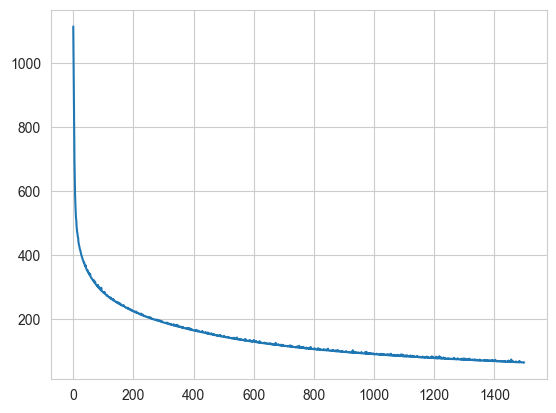

1109


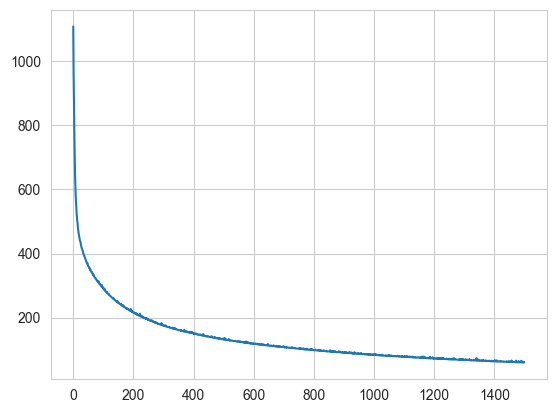

1102


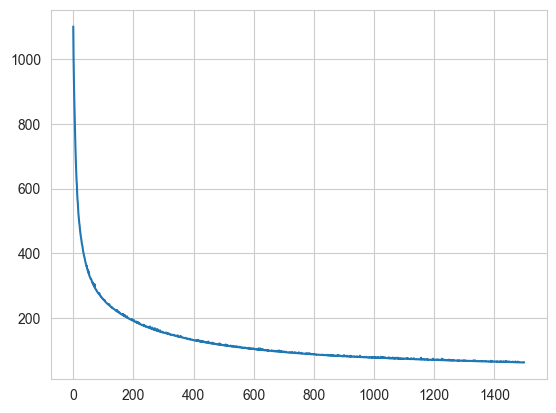

In [78]:
svm_classifiers = trainSVMs(X_train, X_test)

pickle.dump(svm_classifiers,open("models/svm_build.pkl","wb"))

In [79]:
incorrect_withmask = svm_classifiers[0][1]
#cats_humans = svm_classifiers[0][3]
print("kích thước mảng tham số cho incorrect_withmask",incorrect_withmask[0].shape)
print("bias cho cat dog",incorrect_withmask[1])

kích thước mảng tham số cho incorrect_withmask (1, 3072)
bias cho cat dog -0.10954999999999918


In [82]:
#Prediction
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    print(z)
    if z >= 0:
        return 1
    else:
        return -1

def predict(x):
    count = np.zeros((number_of_classes,)) #cat dog 1 
    for i in range(number_of_classes):
        for j in range(i+1, number_of_classes):
            w,b = svm_classifiers[i][j]
            #
            z = binaryPredict(x,w,b)
            #(lớp có tổng điểm lớn nhất) được dự đoán là nhãn lớp.
            if z==1:
                count[j] += 1
            else:
                count[i] += 1

    final_prediction = np.argmax(count)
    return final_prediction

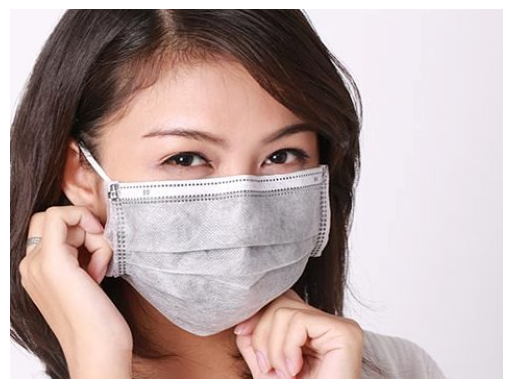

[1.26650682]
[-0.59813605]
[-0.44433302]
1
dự đoán: WithMask


In [87]:
switcher = { 0 : 'IncorrectlyWornMask',1 :'WithMask', 2 :'WithoutMask'}


imgshow = image.load_img("imgthucte/withmask1.jpeg")
plt.imshow(imgshow)
plt.axis('off')
plt.show()
imgpre = image.load_img("imgthucte/withmask1.jpeg", target_size=(32,32))
imgpre_array = image.img_to_array(imgpre)
imgpre_array = np.array(imgpre_array, dtype='float32')/255.0
imgpre_array = imgpre_array.reshape(-1,)

# print(imgpre_array)
pre1 = predict(imgpre_array)
print(pre1)

print("dự đoán:",switcher.get(pre1, "nothing"))

In [88]:
def accuracy(x,y):
    pred = []
    count=0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        pred.append(prediction)
        if prediction==y[i]:
            count += 1
    return count/x.shape[0], pred

In [89]:
acc, ypred = accuracy(X_test, y_test)
print("chất lượng của hàm dự đoán tự viết: ",acc)

[-1.48065925]
[-1.00354328]
[0.41910725]
[-0.57551354]
[-0.28764783]
[0.85396582]
[-0.96472321]
[0.83645128]
[2.15950044]
[1.42789262]
[1.93115846]
[1.09482842]
[-1.07656494]
[-3.89414936]
[-4.73491089]
[0.7465696]
[0.02131972]
[-0.88160504]
[1.94139616]
[-0.5533668]
[-0.94243978]
[0.72224154]
[1.53151982]
[2.07087233]
[-0.03815988]
[-0.16591258]
[-0.60172852]
[-1.14741056]
[-0.16510101]
[0.82971521]
[-0.7280587]
[-0.24439274]
[2.07969556]
[0.59940001]
[0.98639525]
[0.87930127]
[0.78320882]
[-0.64166028]
[-1.08171878]
[0.60131585]
[1.41722572]
[2.15863404]
[1.37802156]
[1.28394478]
[1.29413053]
[0.4481873]
[0.64344987]
[2.47286281]
[-1.74340672]
[-1.97034032]
[0.49474223]
[0.11265233]
[1.92641206]
[2.12394705]
[0.844606]
[-0.18977462]
[-1.59323946]
[1.82433232]
[1.29785137]
[-0.00113401]
[1.01797606]
[1.45460288]
[1.48773264]
[-1.55969433]
[-1.49991003]
[0.12070473]
[-0.5353417]
[1.12090689]
[2.01766223]
[-1.84700134]
[-1.6159447]
[-1.67140474]
[-1.30867811]
[-3.96701577]
[-4.74976074]

In [31]:
#Using scikit
from sklearn import svm
svm_classifier = svm.SVC(kernel='linear', C=1.0, probability=True)
svm_classifier.fit(X_train, y_train)
pickle.dump(svm_classifier,open("models/svm_sklearn.pkl","wb"))
type(X_train)

numpy.ndarray

In [36]:
ypred_sklearn = svm_classifier.predict(X_test)
print("chất lượng khi dùng thư viện Sklearn: ",svm_classifier.score(X_test,y_test))




chất lượng khi dùng thư viện Sklearn:  0.9423076923076923


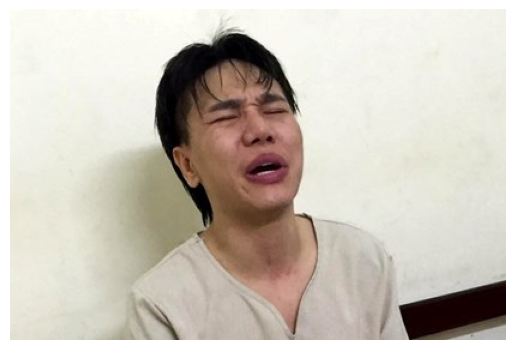

[2]
dự đoán: WithoutMask


In [49]:


imgshow = image.load_img("imgthucte/withoutmask.jpeg")
plt.imshow(imgshow)
plt.axis('off')
plt.show()
imgpre = image.load_img("imgthucte/withoutmask.jpeg", target_size=(32,32))
imgpre_array = image.img_to_array(imgpre)
imgpre_array = np.array(imgpre_array, dtype='float32')/255.0
imgpre_array = imgpre_array.reshape(-1,)

pre2 = svm_classifier.predict([imgpre_array])

switcher = { 0 : 'IncorrectlyWornMask',1 :'WithMask', 2 :'WithoutMask'}

print(pre2)
print("dự đoán:",switcher.get(pre2[0], "nothing"))

In [1]:
#Ma trận nhầm lẫn- Confusion Matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# plot_confusion_matrix
class_names = ['IncorrectlyWornMask', 'WithMask','WithoutMask']
print("SVM classifier")
cnf_matrix = confusion_matrix(y_test, ypred_sklearn)
disp = ConfusionMatrixDisplay(cnf_matrix,display_labels = class_names)
disp.plot()
plt.savefig("imagemodels\cfm_build.png",dpi=120)
plt.show()

#lưu hình ảnh để cho lên giao diện


SVM classifier


NameError: name 'y_test' is not defined

In [44]:
print("Sci-kit Learn")
# plot_confusion_matrix(svm_classifier, image_data_test, labels_test, display_labels=class_names)
#lưu hình ảnh để cho lên giao diện
plt.savefig("imagemodels\cfm_sklearn.png",dpi=120)


Sci-kit Learn


<Figure size 640x480 with 0 Axes>

In [91]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,roc_auc_score

# #mô hình svm tự xây dựng
acc_build = accuracy_score(y_test,ypred)
precision_build = precision_score(y_test,ypred, average='macro')
recall_build = recall_score(y_test,ypred, average='macro')
f1_build = f1_score(y_test,ypred, average='macro')

# #mô hình svm sử dụng thư viện sklearn
acc_library = accuracy_score(y_test,ypred_sklearn)
precision_library = precision_score(y_test,ypred_sklearn, average='macro')
recall_library = recall_score(y_test,ypred_sklearn, average='macro')
f1_library = f1_score(y_test,ypred_sklearn, average='macro')

df_compare = pd.DataFrame({
    'Accuracy':[acc_build,acc_library],
    'Precision score': [precision_build,precision_library],
    'Recall score': [recall_build,recall_library],
    'F1 score': [f1_build,f1_library]

})
df_compare.index = ['Self-built SVM model','Model SVM library' ]
pickle.dump(df_compare,open("models/dataframe_compare.pkl","wb"))
df_compare


,Accuracy,Precision score,Recall score,F1 score
Self-built SVM model,0.930288,0.931782,0.930173,0.930675
Model SVM library,0.942308,0.944307,0.941736,0.942098
